<a href="https://colab.research.google.com/github/nagamachia/OpenFOAM/blob/main/OpenFOAM_Cavity_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. OpenFOAMのインストール

In [ ]:
%%bash
sh -c "wget -O - http://dl.openfoam.org/gpg.key | apt-key add -"
add-apt-repository http://dl.openfoam.org/ubuntu
apt-get update
apt-get -y install openfoam9
pip3 install vtk

OK
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:7 http://dl.openfoam.org/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRe

--2022-05-22 02:53:12--  http://dl.openfoam.org/gpg.key
Resolving dl.openfoam.org (dl.openfoam.org)... 35.179.33.128
Connecting to dl.openfoam.org (dl.openfoam.org)|35.179.33.128|:80... Warning: apt-key output should not be parsed (stdout is not a terminal)
connected.
HTTP request sent, awaiting response... 200 OK
Length: 1710 (1.7K) [application/pgp-keys]
Saving to: ‘STDOUT’

     0K .                                                     100%  340M=0s

2022-05-22 02:53:12 (340 MB/s) - written to stdout [1710/1710]



# 2. 計算Caseを準備

In [ ]:
%%bash
. /opt/openfoam9/etc/bashrc
cp -r $FOAM_TUTORIALS/incompressible/icoFoam/cavity/cavity .

In [ ]:
%cd ./cavity

/content/cavity


# 3. 計算実行

In [ ]:
%%bash
. /opt/openfoam9/etc/bashrc
blockMesh >log.blockMesh 2>&1
icoFoam >log.icoFoam 2>&1 
ls

0
0.1
0.2
0.3
0.4
0.5
constant
log.blockMesh
log.icoFoam
system
VTK


# 4. 可視化

In [ ]:
%%bash
. /opt/openfoam9/etc/bashrc
foamToVTK #計算結果をVTK形式に変換

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  9
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
Build  : 9-b456138dc4bc
Exec   : foamToVTK
Date   : May 22 2022
Time   : 02:53:30
Host   : "b38e56f5bc32"
PID    : 8681
I/O    : uncollated
Case   : /content/cavity
nProcs : 1
sigFpe : Enabling floating point exception trapping (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 10)
allowSystemOperations : Allowing user-supplied system call operations

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
Create time

Create mesh for time = 0

Deleting old VTK files in "/content/cavity/VTK"

Time: 0
    volSc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from scipy.interpolate import griddata
from ipywidgets import interact

def plotVtk(t):
  filename = f"VTK/cavity_{t}.vtk"

  reader = vtk.vtkUnstructuredGridReader()
  reader.SetFileName(filename)
  reader.Update()
  data = reader.GetOutput()

  # cell data から point data変換
  cell2point = vtk.vtkCellDataToPointData()
  cell2point.SetInputData(reader.GetOutput())
  cell2point.Update()
  # 座標データの配列化
  # points = data.GetPoints()
  # coord = vtk_to_numpy(points.GetData()) # (x,y,z)座標の2次元配列
  coord = vtk_to_numpy(cell2point.GetOutput().GetPoints().GetData())

  x = coord[:,0]
  y = coord[:,1]
  z = coord[:,2] 

  # メッシュグリッド用
  xmin, xmax = min(x), max(x)
  ymin, ymax = min(y), max(y)
  xi = np.linspace(xmin, xmax, 100)
  yi = np.linspace(ymin, ymax, 100)

  # GetAbstractArray(0)は圧力、GetAbstractArray(1)は速度ベクトルデータ
  p = vtk_to_numpy(cell2point.GetOutput().GetPointData().GetAbstractArray('p'))
  u = vtk_to_numpy(cell2point.GetOutput().GetPointData().GetAbstractArray('U'))
  speed = np.sqrt(u[:,0]**2 + u[:,1]**2) # ベクトルをスカラー値に変換
  U = u[:,0] # ベクトルをスカラー値に変換
  V = u[:,1] # ベクトルをスカラー値に変換

  # 圧力のコンター図出力
  plt.axes().set_aspect('equal')
  levels = np.linspace(-5,5,21) # 描画する範囲の設定(最小，最大，色の分割数)
  plt.tricontourf(x,y,p,levels=levels,cmap="jet",vmin=-5, vmax=5) #vmin,vmax で色の範囲を設定
  cbar = plt.colorbar()
  cbar.set_ticks(np.arange(-5,5.1,0.5)) # カラーバーの目盛り
  cbar.set_label("p")
  plt.show()

  # 流速のコンター図出力
  plt.axes().set_aspect('equal')
  levels = np.linspace(-1,1,21) 
  plt.tricontourf(x,y,U,levels=levels,cmap="jet", vmin=-1, vmax=1)
  cbar = plt.colorbar()
  cbar.set_ticks(np.arange(-1.0,1.01,0.1)) 
  cbar.set_label("u")
  # plt.quiver(x,y,U,V,color='red',angles='xy',scale_units='xy', scale=10.0) #長さでベクトル場を可視化
  plt.quiver(x,y,U/speed,V/speed,speed,cmap='jet',scale=15.0) #カラーマップでベクトル場を可視化
  plt.show()

  # 流線出力
  plt.axes().set_aspect('equal')
  levels = np.linspace(0,1,21) 
  velocity = griddata((x, y), u, (xi[None,:], yi[:,None]), method='linear') # 速度ベクトルをグリッドに合わせて線形補間
  speed2 = np.sqrt(velocity[:,:,0]**2 + velocity[:,:,1]**2)
  strm = plt.streamplot(xi, yi, velocity[:,:,0], velocity[:,:,1], linewidth=1, arrowstyle="-", density=1.5)
  plt.tricontourf(x,y,speed,levels=levels,cmap="jet", vmin=0, vmax=1)
  cbar = plt.colorbar()
  cbar.set_ticks(np.arange(0,1.01,0.1)) 
  cbar.set_label("|u|")
  plt.show()

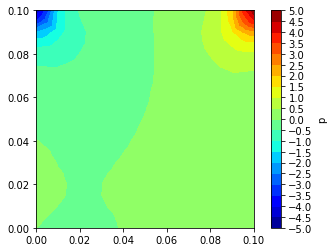

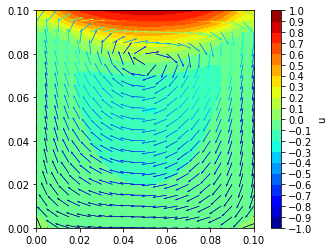

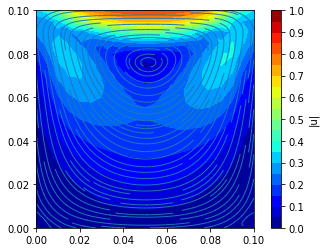

In [ ]:
plotVtk(t=100)

In [ ]:
interact(plotVtk, t=(0,100,20) )

interactive(children=(IntSlider(value=40, description='t', step=20), Output()), _dom_classes=('widget-interact…

<function __main__.plotVtk>

In [ ]:
!cat 0/U

/*--------------------------------*- C++ -*----------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  9
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{
    format      ascii;
    class       volVectorField;
    object      U;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dimensions      [0 1 -1 0 0 0 0];

internalField   uniform (0 0 0);

boundaryField
{
    movingWall
    {
        type            fixedValue;
        value           uniform (1 0 0);
    }

    fixedWalls
    {
        type            noSlip;
    }

    frontAndBack
    {
        type            empty;
    }
}

// ************************************************************************* //


In [ ]:
!sed -i -e "25c \        value           uniform (2 0 0);" 0/U

In [ ]:
!cat 0/U